In [1]:
#Processamento e Análise em Big Data
#Tarefa 05
#Grupo 03
#20/04/2021

In [2]:
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

## Análise Descritiva

In [56]:
data_ = spark.read.csv('pima_indian_diabetes.csv', header=True)

In [4]:
data_.limit(5).toPandas()

,n_pregnant,plasma_glucose_concentration,blood_pressure,triceps_skinfold_thickness,2hours_serum_insulin,body_mass_index,diabtes_pedigree_function,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<i>**Checando o Schema do Dataframe**

In [5]:
data_.printSchema()

root
 |-- n_pregnant: string (nullable = true)
 |-- plasma_glucose_concentration: string (nullable = true)
 |-- blood_pressure: string (nullable = true)
 |-- triceps_skinfold_thickness: string (nullable = true)
 |-- 2hours_serum_insulin: string (nullable = true)
 |-- body_mass_index: string (nullable = true)
 |-- diabtes_pedigree_function: string (nullable = true)
 |-- age: string (nullable = true)
 |-- class: string (nullable = true)



> Vamos converter os valores string para int e float

In [57]:
num_cols = ['n_pregnant', 'class', 'age']
for col in num_cols:
    data_ = data_.withColumn(col, data_[col].cast('int'))

num_cols = ['plasma_glucose_concentration', 'blood_pressure','triceps_skinfold_thickness', 
            '2hours_serum_insulin','body_mass_index', 'diabtes_pedigree_function' ]
for col in num_cols:
    data_ = data_.withColumn(col, data_[col].cast('float'))
    
    
data_.printSchema()    

root
 |-- n_pregnant: integer (nullable = true)
 |-- plasma_glucose_concentration: float (nullable = true)
 |-- blood_pressure: float (nullable = true)
 |-- triceps_skinfold_thickness: float (nullable = true)
 |-- 2hours_serum_insulin: float (nullable = true)
 |-- body_mass_index: float (nullable = true)
 |-- diabtes_pedigree_function: float (nullable = true)
 |-- age: integer (nullable = true)
 |-- class: integer (nullable = true)



copiando Dataframe

In [7]:
schema = data_.schema
X_pd = data_.toPandas()
data_model = spark.createDataFrame(X_pd,schema=schema)
del X_pd
data_model.printSchema()

root
 |-- n_pregnant: integer (nullable = true)
 |-- plasma_glucose_concentration: float (nullable = true)
 |-- blood_pressure: float (nullable = true)
 |-- triceps_skinfold_thickness: float (nullable = true)
 |-- 2hours_serum_insulin: float (nullable = true)
 |-- body_mass_index: float (nullable = true)
 |-- diabtes_pedigree_function: float (nullable = true)
 |-- age: integer (nullable = true)
 |-- class: integer (nullable = true)



<i>**Colunas presentes no Dataframe**

In [8]:
for column in data_.limit(5).toPandas().columns:
    print(column)

n_pregnant
plasma_glucose_concentration
blood_pressure
triceps_skinfold_thickness
2hours_serum_insulin
body_mass_index
diabtes_pedigree_function
age
class


 > n_pregnant  -  Número de vezes que engravidou<br>
 
 > plasma_glucose_concentration -  Concentração de glicose plasmática a 2 horas em um teste oral de tolerância à glicose
 
 > blood_pressure  -  Pressão arterial diastólica (mm Hg)
 
 > triceps_skinfold_thickness -  Espessura da dobra da pele do tríceps (mm)
 
 > 2hours_serum_insulin  -  Insulina sérica de 2 horas (mu U / ml)
 
 > body_mass_index  -  Índice de massa corporal (peso em kg / (altura em m) ^ 2)
 
 > diabtes_pedigree_function -  valores que medem a tendência ao desenvolvimento de diabetes com base nas relações genéticas do indivíduo
 
 > age  -  Idade
 
 > class  -  Presença ou não de diabetes

<i>**Vamos ver as estatísticas das variáveis**

In [9]:
data_.summary().toPandas().T

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
n_pregnant,768,3.8450520833333335,3.36957806269887,0,1,3,6,17
plasma_glucose_concentration,768,120.89453125,31.97261819513622,0.0,99.0,117.0,140.0,199.0
blood_pressure,768,69.10546875,19.355807170644777,0.0,62.0,72.0,80.0,122.0
triceps_skinfold_thickness,768,20.536458333333332,15.952217567727642,0.0,0.0,23.0,32.0,99.0
2hours_serum_insulin,768,79.79947916666667,115.24400235133803,0.0,0.0,29.0,127.0,846.0
body_mass_index,768,31.99257813890775,7.884160293010772,0.0,27.3,32.0,36.6,67.1
diabtes_pedigree_function,768,0.4718763029280429,0.3313285967924436,0.078,0.243,0.371,0.626,2.42
age,768,33.240885416666664,11.760231540678689,21,24,29,41,81
class,768,0.3489583333333333,0.476951377242799,0,0,0,1,1


<i>**Vamos plotar Boxplots das vatiáveis para  ter uma visão geral de dimensão e distribuição dos dados**

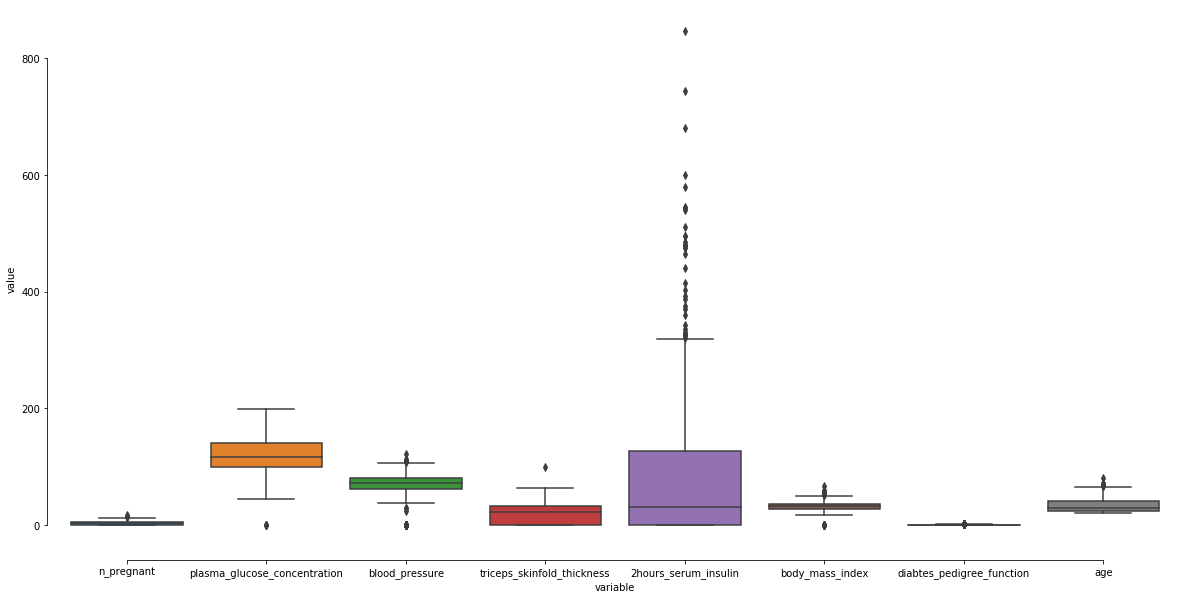

In [58]:
import matplotlib.pyplot as plt 
import seaborn as sns


plt.rcParams['figure.figsize']=(20,10)
tips = sns.load_dataset("tips")

sns.boxplot(x="variable", y="value", data=pd.melt(data_.toPandas().drop(['class'], axis=1)))


sns.despine(offset=10, trim=True)

> No gráfico acima fica evidente que algumas variáveis apresentam bastantes outliers, o que pode impactar na performance dos modelos de Machine learning

> Futuramente iremos tratá-los a fim de verificar o quanto esses outliers interferem no modelo 

<i>**Vamos plotar uma Scatterplot Matrix para ver se conseguimos enxergar relações entre as variáveis, assim como se existe alguma Decision Boundery aparente aos nossos olhos**

/home/matheus/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/matheus/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


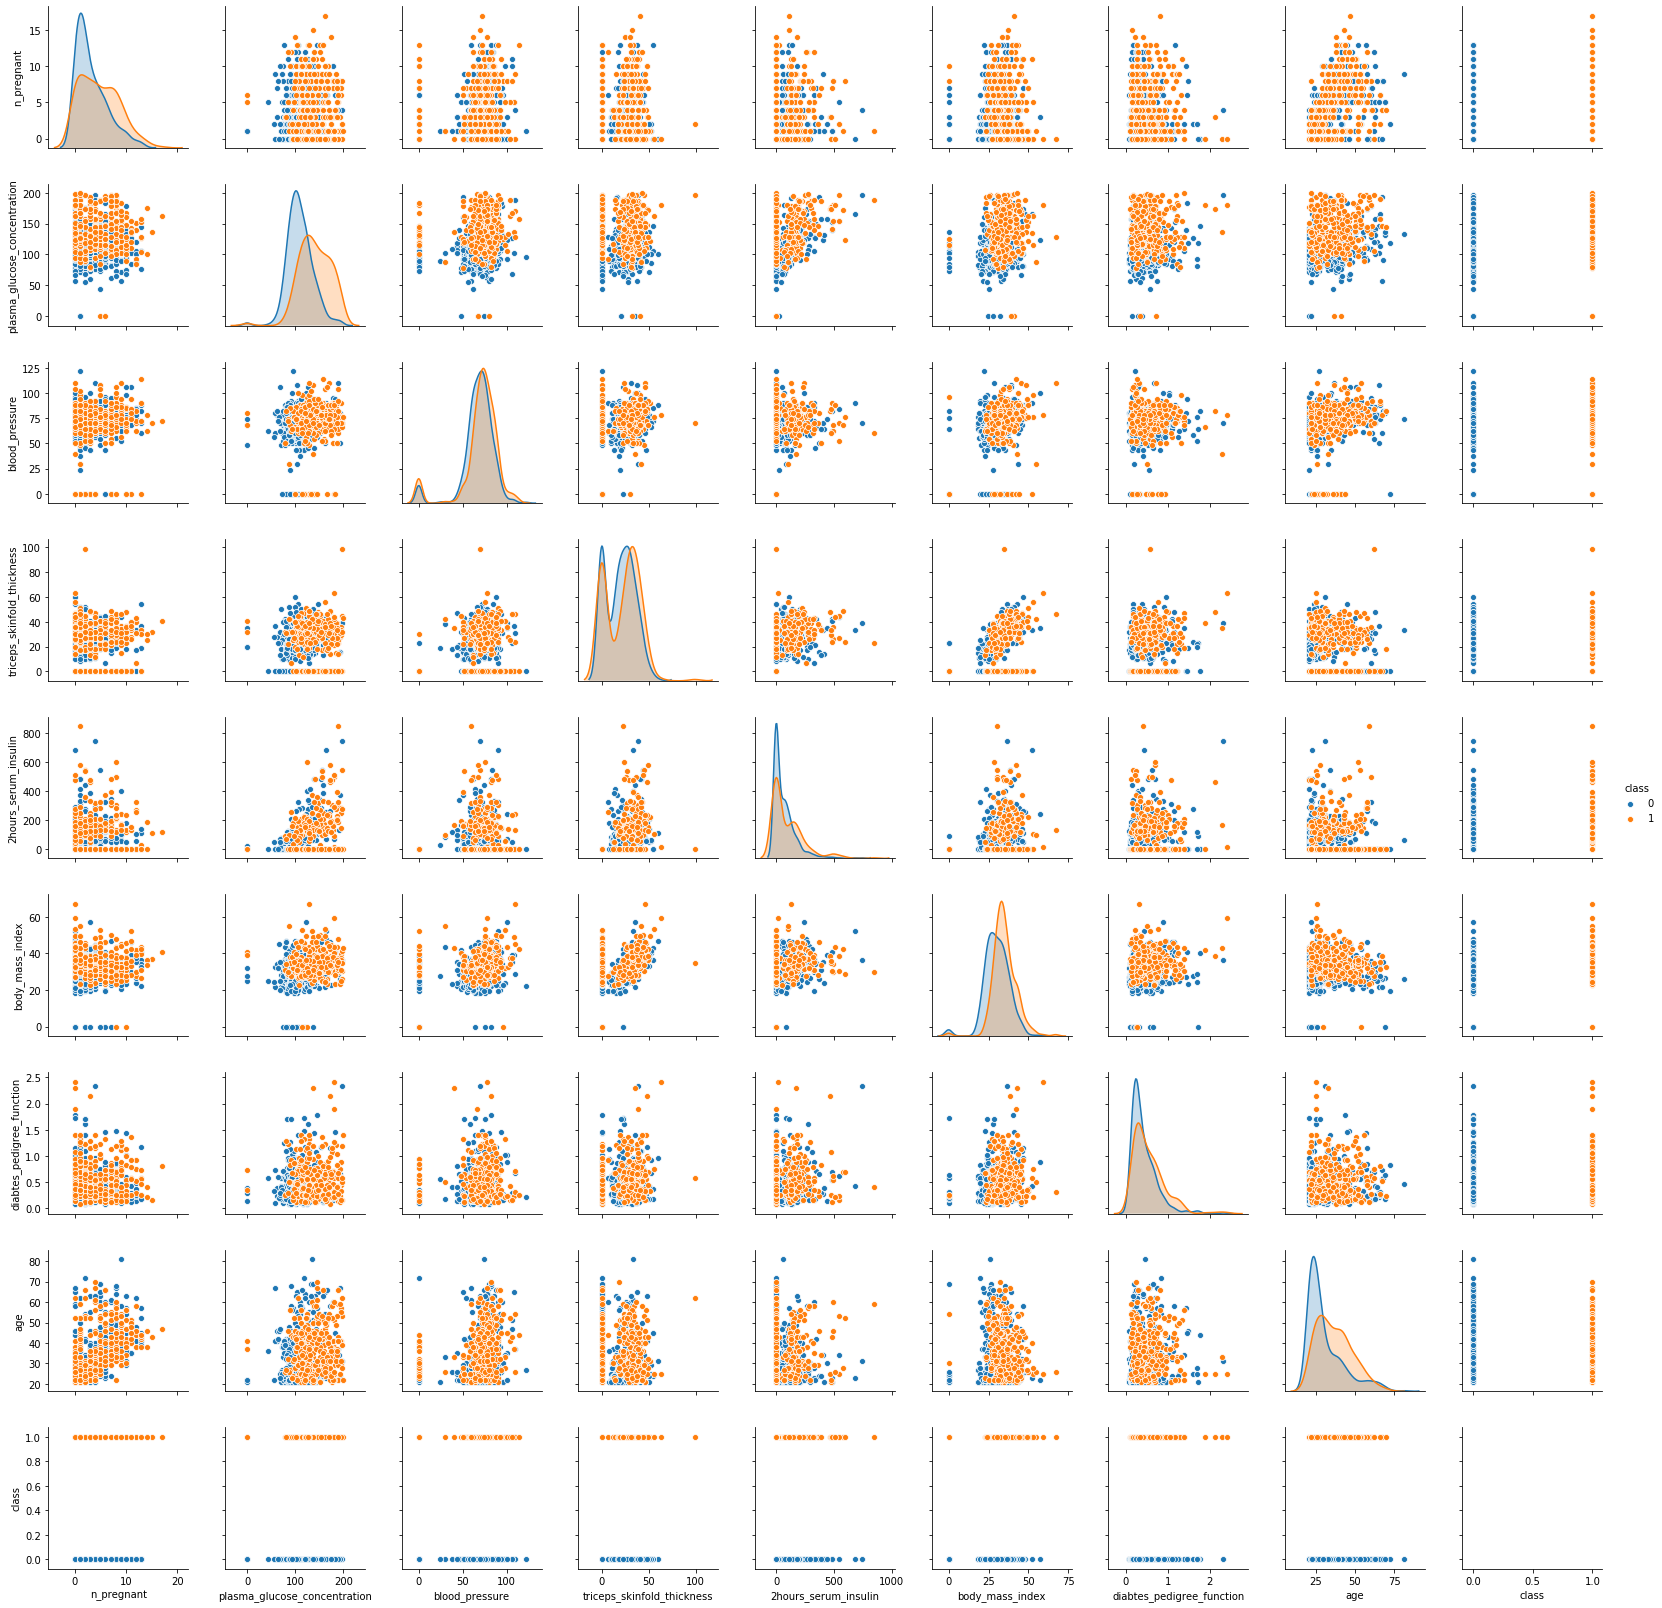

In [11]:
sns.pairplot(data_.toPandas(), hue="class");

Notas:
>
>
>



<i>**Agora que já tivemos um insight visual, vamos mensurar numericalmente o qual forte são as relações entre essas variáveis usando a matrix de correlação**

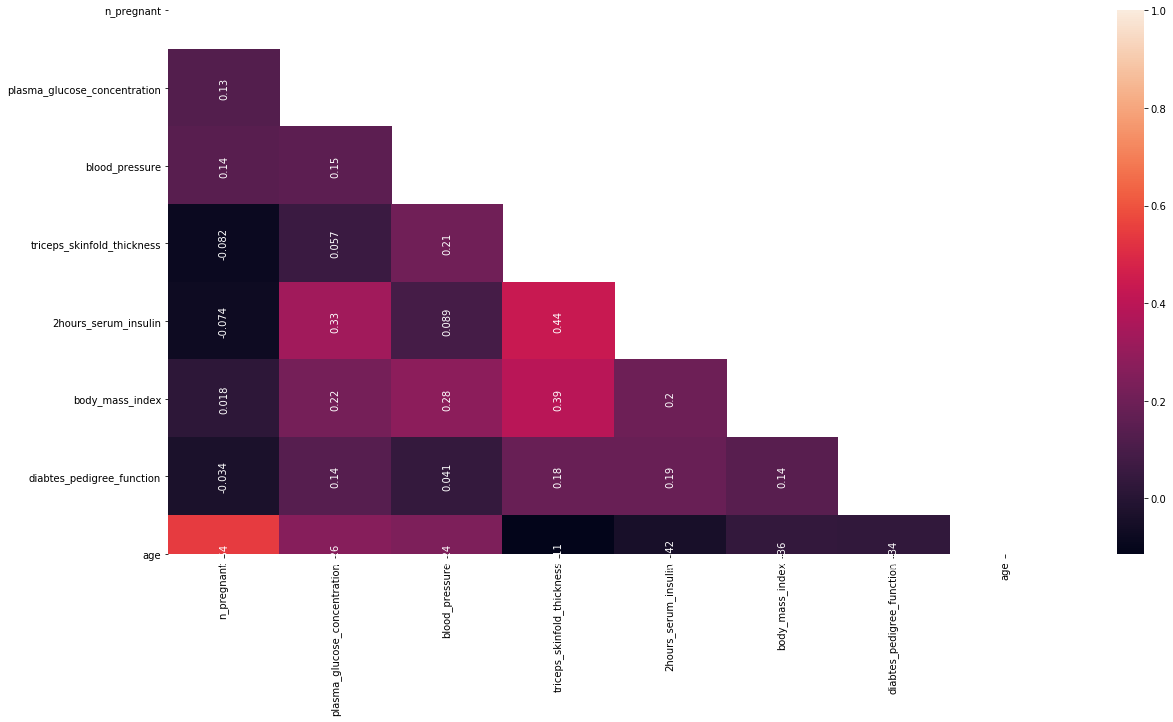

In [59]:
import numpy as np

data_corr = data_.toPandas().drop(['class'], axis=1).corr()

mask = np.triu(data_corr)
sns.heatmap(data_corr, annot=True, mask=mask,annot_kws={'rotation': 90});

<i>**Dentre as variáveis independentes do modelo "n_pregnant" é a única que aparenta ter um comportamento discreto. Abaixo iremos explorar ela um pouco**
    
 <i>Valores únicos e sua ocorrência:

In [13]:
data_.groupby('n_pregnant').count().toPandas().sort_values(by='count', ascending=False)

,n_pregnant,count
1,1,135
16,0,111
15,2,103
4,3,75
9,4,68
5,5,57
3,6,50
11,7,45
10,8,38
7,9,28


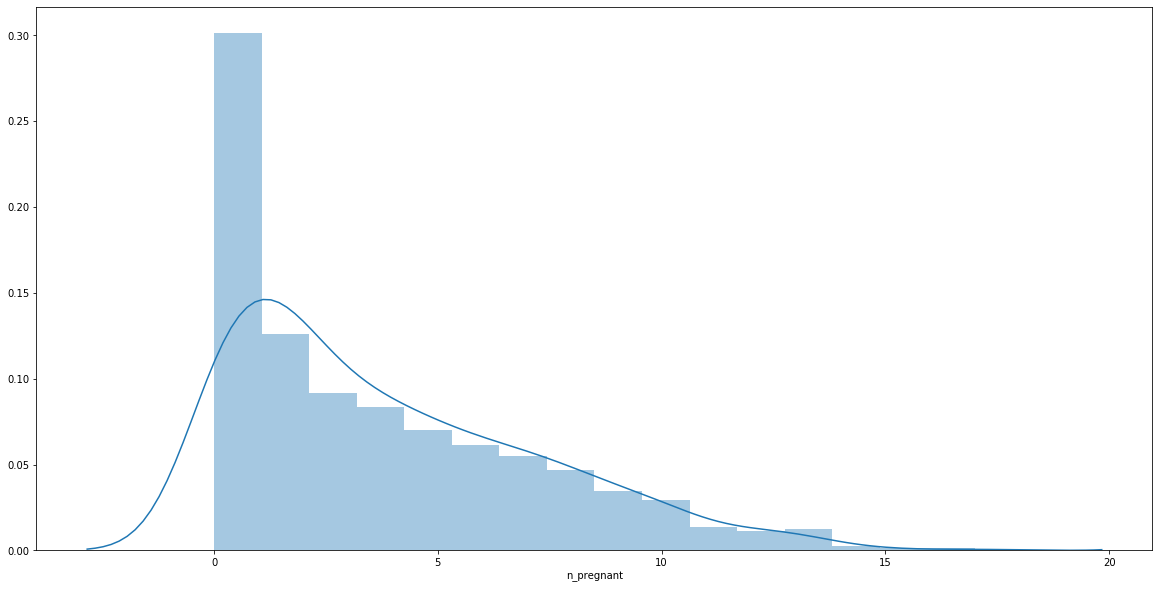

In [60]:
sns.distplot(data_.toPandas()["n_pregnant"]);

<i> Vamos fazer um teste de normalidade

In [15]:
from scipy import stats

x = data_.select('n_pregnant').toPandas()['n_pregnant']

k2, p = stats.normaltest(x)
alpha = 1e-3
print("p = {:g}".format(p))
      
if p < alpha:
      print("The null hypothesis can be rejected") 
else:
      print("The null hypothesis cannot be rejected")
    

p = 3.91429e-18
The null hypothesis can be rejected


<i>O teste rejeitou a hipotese nula, consequentemente a coluna "n_pregnant" não apresenta uma curva normal

## Criando os modelos ML

#### Antes de começar o preprocessamento do Dataframe vamos treinar um modelo sem e verificar as metricas com os dados crus a fim de criar um benchmark

In [16]:
stages = []

label_stringIdx = StringIndexer(inputCol = 'class', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = ['n_pregnant', 'age','plasma_glucose_concentration', 'blood_pressure','triceps_skinfold_thickness', 
            '2hours_serum_insulin','body_mass_index', 'diabtes_pedigree_function']

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [17]:
cols = data_.columns

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data_)
data_ = pipelineModel.transform(data_)
selectedCols = ['label', 'features'] + cols
data_ = data_.select(selectedCols)
data_.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- n_pregnant: integer (nullable = true)
 |-- plasma_glucose_concentration: float (nullable = true)
 |-- blood_pressure: float (nullable = true)
 |-- triceps_skinfold_thickness: float (nullable = true)
 |-- 2hours_serum_insulin: float (nullable = true)
 |-- body_mass_index: float (nullable = true)
 |-- diabtes_pedigree_function: float (nullable = true)
 |-- age: integer (nullable = true)
 |-- class: integer (nullable = true)



In [18]:
# Preparando pros modelos
train, test = data_.randomSplit([0.7, 0.3], seed = 2019)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 544
Test Dataset Count: 224


### Logistic Regression Model

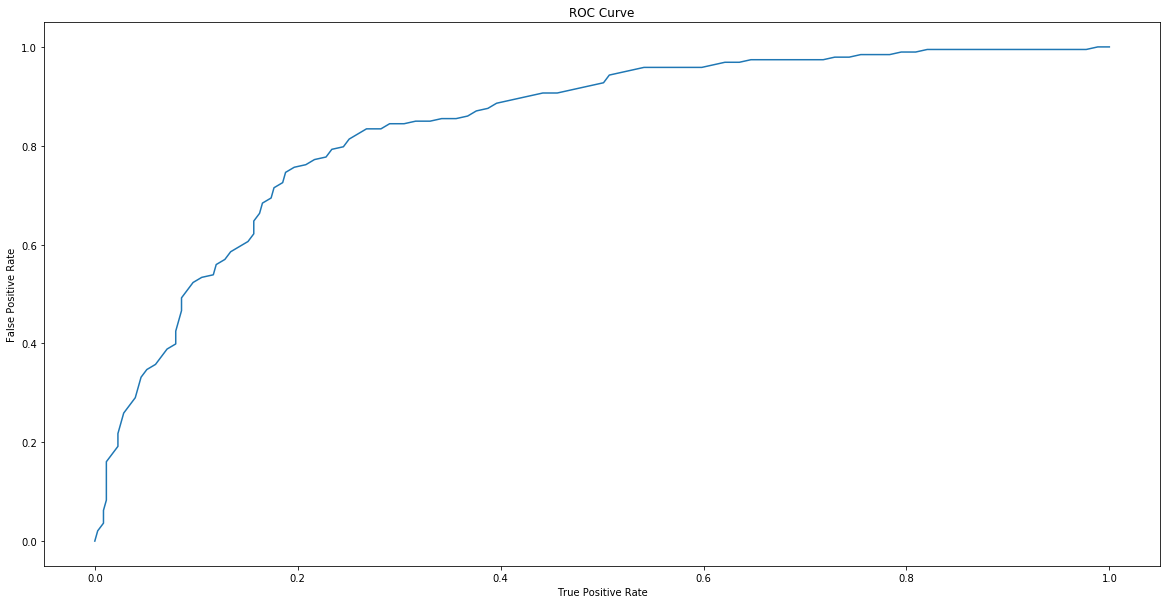

Training set areaUnderROC: 0.8412677324594429


In [62]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

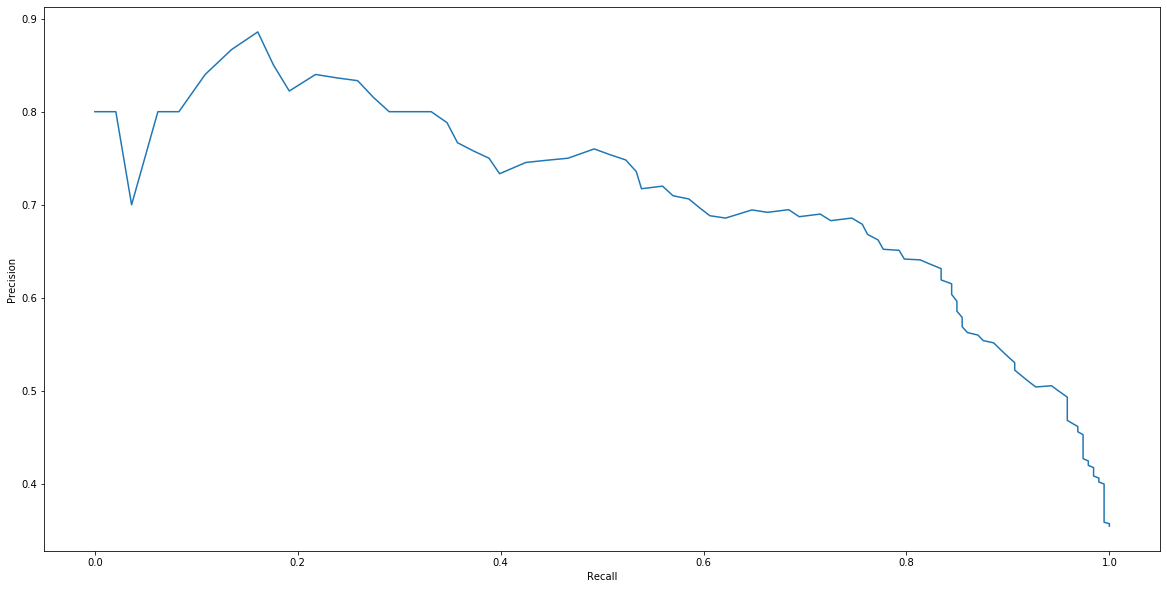

In [63]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = lrModel.transform(test)
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8171812080536911


### Decision Tree Classifier

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.720268456375839


### Random Forest Classifier

In [23]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8136912751677854


### Gradient-Boosted Tree Classifier

In [24]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7434004474272928


### Gradient-Boosted Tree Classifier + Cross  Validator + Grid Search

In [25]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8207606263982102

### Nosso Benchmark

> Logistic Regression Model - Area Under ROC 0.8171812080536911

> Decision Tree Classifier - Area Under ROC: 0.720268456375839

> Random Forest Classifier - Area Under ROC: 0.8136912751677854

> Gradient-Boosted Tree Classifier - Area Under ROC: 0.7434004474272928

> Gradient-Boosted Tree Classifier + Cross Validator + Grid Search -  Area Under ROC:0.8207606263982102

## Criando nosso modelo

<i>**Vamos desenvolver algumas funções de processamento, treinamento e teste, para que em seguida possamos rodar todas possibilidades de modelos, considerando varios tipos de processamento difernetes**
    
<i> Funções de processamento:
   

In [26]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql import functions as f

> Remover outliers

In [44]:
# outliers_parameters = [False,'StdDev']

def remove_outliers(df, outliers_type):
    if outliers_type == 'StdDev':
        data = df.where(df.body_mass_index  > 10.0)
        data = data.where(data.triceps_skinfold_thickness  > 0)
        data = data.where(data['2hours_serum_insulin']  > 0 )
        data = data.where( data['2hours_serum_insulin']  < 350)
        return data
  
    else:
        return df


> Fazer amostragem nas classes - balanceamento

In [28]:
#  sample_parameters = [False, True]

def balance_dataframe(df, sample_type):
    if sample_type == True:
        lenght = []
        sample_list = []
        lenght.append(df.filter(df['class'] == 1).count())
        lenght.append(df.filter(df['class'] == 0).count())
        sample_size = min(lenght)
        sample_list.extend(df.filter(df['class'] == 1).rdd.takeSample(False, sample_size, seed=0))
        sample_list.extend(df.filter(df['class'] == 0).rdd.takeSample(False, sample_size, seed=0))

        data = sqlContext.createDataFrame(sample_list)
        return data
    else:
        return df

> Remover agrupamento de duplicados remanecentes

In [29]:
# remove_distinct_parameters = [False,['n_pregnant','2hours_serum_insulin', 'age', 'class'],[ 'age', 'class']]

def remove_dinstinct(df, remove_distinct_type):
    if remove_distinct_type == False:
        return df
    else:
        data = df.drop_duplicates(subset=remove_distinct_type)
        return data

> Normalizar valores - MinMax / Standalizer

In [30]:
# normalization_parameters = [False,'MinMax', 'Standalizer']


def normalize_dataframe(df, normalization_type):
    
    
    columns_to_scale = []
    stages = []
    
    for column in df.columns:
        if column == "class": continue
        columns_to_scale.append(column)
    
    if normalization_type == 'MinMax':
        

        label_stringIdx = StringIndexer(inputCol = 'class', outputCol = 'label')
        stages += [label_stringIdx]
        pipeline = Pipeline(stages = stages)
        pipelineModel = pipeline.fit(df)
        df_result = pipelineModel.transform(df)

        assemblers = VectorAssembler(inputCols=columns_to_scale, outputCol="features_preprocessing")
        vector = assemblers.transform(df_result)
        standard_scaler = MinMaxScaler(inputCol="features_preprocessing", outputCol="features")
        train = standard_scaler.fit(vector).transform(vector)
        return train 
        
    elif normalization_type == 'Standalizer':
        
        label_stringIdx = StringIndexer(inputCol = 'class', outputCol = 'label')
        stages += [label_stringIdx]
        pipeline = Pipeline(stages = stages)
        pipelineModel = pipeline.fit(df)
        df_result = pipelineModel.transform(df)

        assemblers = VectorAssembler(inputCols=columns_to_scale, outputCol="features_preprocessing")
        vector = assemblers.transform(df_result)
        standard_scaler = StandardScaler(inputCol="features_preprocessing", outputCol="features")
        train = standard_scaler.fit(vector).transform(vector)
        return train
    
    else:
       
        label_stringIdx = StringIndexer(inputCol = 'class', outputCol = 'label')
        stages += [label_stringIdx]
        
        assembler = VectorAssembler(inputCols=columns_to_scale, outputCol="features")
        stages += [assembler]

        cols = df.columns

        pipeline = Pipeline(stages = stages)
        pipelineModel = pipeline.fit(df)
        df_result = pipelineModel.transform(df)
        selectedCols = ['label', 'features'] + cols
        df_result = df_result.select(selectedCols)
        return df_result

Modelos:

In [46]:
def apply_Logistic_Regression_Model(df):
    
    train, test = df.randomSplit([0.8, 0.2], seed = 2019)
    
    #tocar esssa linha
    model = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
    
    evaluator = BinaryClassificationEvaluator()
    
     # Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
             .addGrid(model.regParam,[0.02])
             .addGrid(model.elasticNetParam,[0.2])
             .build())

        # Create 5-fold CrossValidator
    cv = CrossValidator(estimator = model,
                      estimatorParamMaps = paramGrid,
                      evaluator = evaluator,
                      numFolds = 5)
    # Run cross validations.
    cvModel = cv.fit(train)
 

    # Use test set here so we can measure the accuracy of our model on new data
    predictions = cvModel.transform(test)

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    acc = evaluator.evaluate(predictions)
    auc = BinaryClassificationMetrics(predictions['label','prediction'].rdd).areaUnderROC
    print('Accuracy:', acc)
    print('AUC:',auc)
    return acc, auc

In [47]:
def apply_Decision_Tree_Model(df):
    train, test = df.randomSplit([0.8, 0.2], seed = 2019)
    
    #tocar esssa linha
    model = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
    
    evaluator = BinaryClassificationEvaluator()
    
     # Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(model.maxDepth, [2, 20])
                 .addGrid(model.maxBins, [10, 40])
                 .build())

        # Create 5-fold CrossValidator
    cv = CrossValidator(estimator = model,
                      estimatorParamMaps = paramGrid,
                      evaluator = evaluator,
                      numFolds = 5)
    # Run cross validations.
    cvModel = cv.fit(train)
 

    # Use test set here so we can measure the accuracy of our model on new data
    predictions = cvModel.transform(test)

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    acc = evaluator.evaluate(predictions)
    auc = BinaryClassificationMetrics(predictions['label','prediction'].rdd).areaUnderROC
    print('Accuracy:', acc)
    print('AUC:',auc)
    return acc, auc

In [48]:
def apply_Random_Forest_Model(df):
    
    train, test = df.randomSplit([0.8, 0.2], seed = 2019)
    # Create an initial RandomForest model.
    model = RandomForestClassifier(labelCol="label", featuresCol="features")
    # Evaluate model
    evaluator = BinaryClassificationEvaluator()
    # Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
             .addGrid(model.maxDepth, [2 ])
             .addGrid(model.maxBins, [10,])
             .addGrid(model.numTrees, [5])
             .build())
   
    # Create 5-fold CrossValidator
    cv = CrossValidator(estimator = model,
                      estimatorParamMaps = paramGrid,
                      evaluator = evaluator,
                      numFolds = 5)
    # Run cross validations.
    cvModel = cv.fit(train)
 

    # Use test set here so we can measure the accuracy of our model on new data
    predictions = cvModel.transform(test)

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    acc = evaluator.evaluate(predictions)
    auc = BinaryClassificationMetrics(predictions['label','prediction'].rdd).areaUnderROC
    print('Accuracy:', acc)
    print('AUC:', auc)
    return acc, auc

In [49]:
def apply_Gradient_BoostedT_Model(df):
    
    train, test = df.randomSplit([0.8, 0.2], seed = 2019)
    
    #tocar esssa linha
    model = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10 )
    
    evaluator = BinaryClassificationEvaluator()
    
     # Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
             .addGrid(model.maxDepth, [2, ])
             .addGrid(model.maxBins, [20])
             .addGrid(model.maxIter, [10])
             .build())

        # Create 5-fold CrossValidator
    cv = CrossValidator(estimator = model,
                      estimatorParamMaps = paramGrid,
                      evaluator = evaluator,
                      numFolds = 5)
    # Run cross validations.
    cvModel = cv.fit(train)
 

    # Use test set here so we can measure the accuracy of our model on new data
    predictions = cvModel.transform(test)

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    acc = evaluator.evaluate(predictions)
    auc = BinaryClassificationMetrics(predictions['label','prediction'].rdd).areaUnderROC
    print('Accuracy:', acc)
    print('AUC:',auc)
    return acc, auc

In [50]:
def apply_MultiLayer_Perceptron(df):
    train, test = df.randomSplit([0.8, 0.2], seed = 2019)
                 
    model = MultilayerPerceptronClassifier(featuresCol = 'features', labelCol = 'label')
    evaluator = BinaryClassificationEvaluator()
    paramGrid = (ParamGridBuilder()
        .addGrid(model.maxIter,[10, 20]) 
        .addGrid(model.stepSize ,[0.03, 0.01]) 
        .addGrid(model.solver ,['l-bfgs', 'gd']) 
        .addGrid(model.layers, [[8, 12, 2], [8, 5, 2], [8, 5, 4, 2]]) 
        .build())
                 
        # Create 5-fold CrossValidator
    cv = CrossValidator(estimator = model, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 5)
    # Run cross validations.
    cvModel = cv.fit(train)


    # Use test set here so we can measure the accuracy of our model on new data
    predictions = cvModel.transform(test)

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    acc = f
    evaluator.evaluate(predictions)
    auc = BinaryClassificationMetrics(predictions['label','prediction'].rdd).areaUnderROC
    print('Accuracy:', acc)
    print('AUC:',auc)
    return acc, auc

**Ordem que as funções devem rodar**

 > data = remove_outliers(data_, outliers_tag)
 
 > data = balance_dataframe(data, sample_tag)
 
 > data = remove_dinstinct(data, remove_distinct_tag)
 
 > data = normalize_dataframe(data, normalization_tag)
 
 >apply_Logistic_Regression_Model(data)

<i>**No codigo a baixo iremos fazer um loop entre todos metodos de processamento de modelos de machine learnin para encontrar qual o melhor pipeline de processamento/modelo para nosso conjunto de dados**

In [51]:
from datetime import datetime
start = datetime.now()

# models = ["MLP","GBT","RDF","DCT","LGR"]


outliers_parameters = [False,'StdDev','DropCol']
sample_parameters = [False, True]
remove_distinct_parameters = [False,['n_pregnant','2hours_serum_insulin', 'age', 'class'],[ 'age', 'class']]
normalization_parameters = [False,'MinMax', 'Standalizer']
models = ["RDF","LGR","GBT"]

result = []

for model in models:
    for outliers_tag in outliers_parameters:
        for sample_tag in sample_parameters:
            for remove_distinct_tag in remove_distinct_parameters:
                for normalization_tag in normalization_parameters:
                
                    dic = {}

                    data = remove_outliers(data_model, outliers_tag)
                    data = balance_dataframe(data, sample_tag)
                    data = remove_dinstinct(data, remove_distinct_tag)
                    data = normalize_dataframe(data, normalization_tag)

                    print(model)
                    if model == "MLP":
                        acc, auc = apply_MultiLayer_Perceptron(data)

                    elif model == "GBT":
                       acc, auc = apply_Gradient_BoostedT_Model(data)

                    elif model == "RDF":
                        acc, auc = apply_Random_Forest_Model(data)

                    elif model == "DCT":
                        acc, auc = apply_Decision_Tree_Model(data)

                    elif model == "LGR":
                        acc, auc = apply_Logistic_Regression_Model(data)
                    
                    print(" ")
                    dic["Model Name"] = model
                    dic["outliers_tag"] = outliers_tag
                    dic["sample_tag"] = sample_tag
                    dic["remove_distinct_tag"] = remove_distinct_tag
                    dic["normalization_tag"] = normalization_tag
                    dic["Acuracia"] = acc
                    dic["AUC"] = auc
                    result.append(dic)
                    
                    
df = pd.DataFrame(result)
df = df.sort_values(by=['AUC'], ascending=False)

stop = datetime.now()
print('Time: ', stop - start) 

RDF
Accuracy: 0.8453608247422681
AUC: 0.7697368421052632
 
RDF
Accuracy: 0.7912234042553192
AUC: 0.6758209822725951
 
RDF
Accuracy: 0.7912234042553192
AUC: 0.6758209822725951
 
RDF
Accuracy: 0.7703488372093023
AUC: 0.7881578947368422
 
RDF
Accuracy: 0.8031666666666665
AUC: 0.8331043956043955
 
RDF
Accuracy: 0.8031666666666665
AUC: 0.8331043956043955
 
RDF
Accuracy: 0.6212121212121212
AUC: 0.5833333333333334
 
RDF
Accuracy: 0.6262626262626262
AUC: 0.5625
 
RDF
Accuracy: 0.6262626262626262
AUC: 0.5625
 
RDF
Accuracy: 0.8359113712374582
AUC: 0.7317124735729387
 
RDF
Accuracy: 0.8292224080267557
AUC: 0.7609427609427609
 
RDF
Accuracy: 0.8292224080267557
AUC: 0.7609427609427609
 
RDF
Accuracy: 0.7361793611793612
AUC: 0.6512422360248447
 
RDF
Accuracy: 0.7751842751842751
AUC: 0.711111111111111
 
RDF
Accuracy: 0.7751842751842751
AUC: 0.711111111111111
 
RDF
Accuracy: 0.8
AUC: 0.775
 
RDF
Accuracy: 0.9861111111111112
AUC: 0.875
 
RDF
Accuracy: 0.9861111111111112
AUC: 0.875
 
RDF
Accuracy: 0.87

In [54]:
df.head(15)

,Model Name,outliers_tag,sample_tag,remove_distinct_tag,normalization_tag,Acuracia,AUC
22,RDF,StdDev,False,"[n_pregnant, 2hours_serum_insulin, age, class]",MinMax,0.950625,0.962963
23,RDF,StdDev,False,"[n_pregnant, 2hours_serum_insulin, age, class]",Standalizer,0.950625,0.962963
76,LGR,StdDev,False,"[n_pregnant, 2hours_serum_insulin, age, class]",MinMax,0.890000,0.916667
124,GBT,False,True,"[age, class]",MinMax,0.930556,0.909091
125,GBT,False,True,"[age, class]",Standalizer,0.930556,0.909091
161,GBT,DropCol,True,"[age, class]",Standalizer,0.930556,0.909091
160,GBT,DropCol,True,"[age, class]",MinMax,0.930556,0.909091
21,RDF,StdDev,False,"[n_pregnant, 2hours_serum_insulin, age, class]",False,0.896875,0.887500
52,RDF,DropCol,True,"[age, class]",MinMax,0.986111,0.875000
53,RDF,DropCol,True,"[age, class]",Standalizer,0.986111,0.875000


## Detalhes do melhor modelo